In [0]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import pandas

In [0]:
def get_data():
    header = ['tweet','label']
    data_set = pandas.read_csv('cleaned_data.txt',delimiter='\t',names = header)
    return data_set

def split_tweet(tweet):
    return tweet.split()    


In [0]:
data_set = get_data()

In [0]:
glove = torchtext.vocab.GloVe(name="twitter.27B",dim=50)

# inser padding character into glove embedding, we overwrite the first element and that's okay
# because we don't use the first element in our vocab
glove.vectors[0] = torch.tensor(np.zeros(50))

In [11]:
len(data_set)

160568

In [12]:
data_set

,tweet,label
0,i feel like a baby kangaroo stuck in its mothe...,1
1,"oh , the irony if misha wins the choice tv sc...",2
2,"i miss you to , you so fake now",2
3,"i miss you to , you so fake now",4
4,i know,1
5,things can change so quickly,1
6,all me &amp ; vic do is laugh . . anybody o...,1
7,my eyes are in pain . cant get over the movie...,1
8,eye need to get these brows done asap,1
9,i almost choked on my retainer just now,1


In [0]:
def data_set_to_glove_index(glove_dict):
    tweets_ints, encoded_labels = [],[]
    for i in range(len(data_set)):
        tweet = data_set['tweet'][i]
        label = data_set['label'][i]
        if(type(tweet) != str):
            continue
        idxs = [glove_dict.stoi[w]        # lookup the index of word
            for w in tweet.split()
            if w in glove_dict.stoi] # keep words that has an embedding
        if not idxs: # ignore tweets without any word with an embedding
            continue
        tweets_ints.append(idxs)
        encoded_labels.append(label)
    return tweets_ints, encoded_labels

In [0]:
tweets_ints, encoded_labels = data_set_to_glove_index(glove)

In [15]:
from collections import Counter
# outlier review stats
tweets_lens = Counter([len(x) for x in tweets_ints])
print("Zero-length tweets: {}".format(tweets_lens[0]))
print("Maximum tweet length: {}".format(max(tweets_lens)))

Zero-length tweets: 0
Maximum tweet length: 62


In [0]:
def pad_features(tweets_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(tweets_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(tweets_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [0]:
seq_length = max(tweets_lens)

features = pad_features(tweets_ints, seq_length=seq_length)
encoded_labels = np.array(encoded_labels)

In [18]:
print(features[:30,])

[[     0      0      0 ...    221   9193  50306]
 [     0      0      0 ... 116746   3094      1]
 [     0      0      0 ...     55   1271    110]
 ...
 [     0      0      0 ...    145  35628     79]
 [     0      0      0 ...     15     66     75]
 [     0      0      0 ...     29  13278  27993]]


### Train, Validation, Test Split

In [0]:
from sklearn.utils import shuffle
features, encoded_labels = shuffle(features, encoded_labels)

In [20]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(127928, 62) 
Validation set: 	(15991, 62) 
Test set: 		(15991, 62)


### DataLoader and Batching

In [0]:
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [33]:
len(train_loader)

2558

### Building the model

In [0]:
class TweetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, use_gpu):
        super(TweetLSTM, self).__init__()
        self.use_gpu = use_gpu
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        
        if self.use_gpu:
          h0 = torch.zeros(1, x.size(0), self.hidden_size).cuda()
          c0 = torch.zeros(1, x.size(0), self.hidden_size).cuda()
        else:
          h0 = torch.zeros(1, x.size(0), self.hidden_size)
          c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out
num_classes = 6
model = TweetLSTM(input_size=50, hidden_size=50, num_classes=num_classes,use_gpu=True)

In [46]:
def get_accuracy(model, data_loader, use_gpu):
    if use_gpu:
      model.cuda()
    correct, total = 0, 0
    for tweets, labels in data_loader:
        if use_gpu:
          tweets,labels  = tweets.cuda(), labels.cuda()
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return float(correct) / float(total)
  

get_accuracy(model, test_loader,use_gpu = True)


0.058683385579937304

In [0]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5,use_gpu=True):
    if use_gpu:
      model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    counter = 0
    for epoch in range(num_epochs):
        batch_loss = []
        for tweets, labels in train:
            if use_gpu:
              tweets,labels  = tweets.cuda(), labels.cuda()
            counter += 1
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            batch_loss.append(float(loss))
            if counter % 100 == 0:
              print("Step %d of Epoch: %d; Loss %f " % ( counter/100 ,epoch+1,np.mean(batch_loss)))
        counter = 0
        epoch_loss = np.mean(batch_loss)
        losses.append(epoch_loss)
        
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader,use_gpu))
        valid_acc.append(get_accuracy(model, valid_loader,use_gpu))
        print("Final Result for Epoch %d: Loss %f; Val Acc %f; Train Acc %f" % (
              epoch+1, epoch_loss, valid_acc[-1], train_acc[-1]))
        print("-------------------------------------------------------------")
        
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Step 1 of Epoch: 1; Loss 1.631976 
Step 2 of Epoch: 1; Loss 1.604524 
Step 3 of Epoch: 1; Loss 1.591430 
Step 4 of Epoch: 1; Loss 1.582805 
Step 5 of Epoch: 1; Loss 1.575784 
Step 6 of Epoch: 1; Loss 1.568041 
Step 7 of Epoch: 1; Loss 1.564002 
Step 8 of Epoch: 1; Loss 1.561225 
Step 9 of Epoch: 1; Loss 1.558716 
Step 10 of Epoch: 1; Loss 1.556215 
Step 11 of Epoch: 1; Loss 1.554492 
Step 12 of Epoch: 1; Loss 1.551673 
Step 13 of Epoch: 1; Loss 1.550601 
Step 14 of Epoch: 1; Loss 1.548617 
Step 15 of Epoch: 1; Loss 1.546160 
Step 16 of Epoch: 1; Loss 1.543697 
Step 17 of Epoch: 1; Loss 1.542441 
Step 18 of Epoch: 1; Loss 1.540878 
Step 19 of Epoch: 1; Loss 1.539657 
Step 20 of Epoch: 1; Loss 1.538305 
Step 21 of Epoch: 1; Loss 1.537903 
Step 22 of Epoch: 1; Loss 1.536569 
Step 23 of Epoch: 1; Loss 1.535746 
Step 24 of Epoch: 1; Loss 1.535071 
Step 25 of Epoch: 1; Loss 1.533912 
Final Result for Epoch 1: Loss 1.533515; Val Acc 0.358495; Train Acc 0.357928
-------------------------------

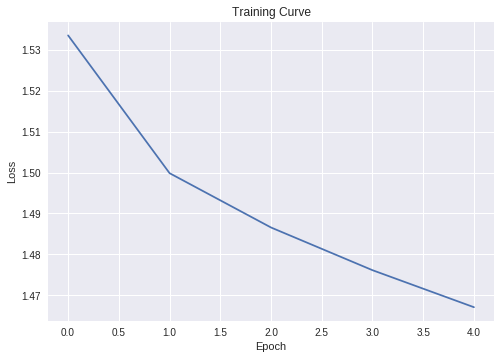

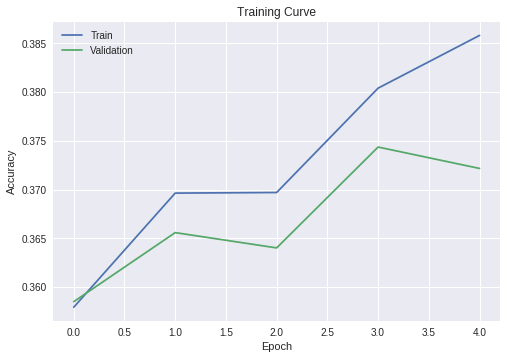

total training time: 217 s


In [62]:
import time
start = time.time()
model = TweetLSTM(input_size=50, hidden_size=50, num_classes=num_classes,use_gpu=True)
train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-3,use_gpu=True)
end = time.time()
print("total training time:", int(end -start), "s")

### Saving the model

In [0]:
#torch.save(model.state_dict(), 'checkpoint.pth')

### Loading the model

In [0]:
state_dict = torch.load('checkpoint.pth')

In [0]:
model.load_state_dict(state_dict)

### Inference

In [0]:
# Tweet Test
happy_tweet = 'Im happy'
sad_tweet = 'Im sad'
angry = 'Im angry'
surprised_tweet = 'Im surprised'
disgusted_tweet = 'Im disgusted'
afraid_tweet = 'Im afraid'

In [0]:
def tweet_to_glove_index(tweet,glove_dict):
    tweets_ints = []
    tweet = tweet.lower()
    idxs = [glove_dict.stoi[w]        # lookup the index of word
            for w in tweet.split()
            if w in glove_dict.stoi] # keep words that has an embedding
    tweets_ints.append(idxs)
    return tweets_ints

In [0]:
int_to_emotion = {0:'Happy', 1:'Sad' , 2:'Angry', 3:'Surprised', 4:'Disgusted', 5:'Afraid'}

def predict(model, test_tweet, sequence_length=max(tweets_lens)):
    
    
    # tokenize tweet
    test_ints = tweet_to_glove_index(test_tweet,glove)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    
    # get the output from the model
    output = model(feature_tensor)
    
    # convert output probabilities to predicted class (0 or 1)
    output_prob = nn.functional.softmax(output,dim=1)
    top_n_pred = output_prob.topk(3,dim=1) ## top 3 preds
    top_n_pred_prob, top_n_pred_index = top_n_pred[0].detach().numpy()[0], top_n_pred[1].detach().numpy()[0]
    print(test_tweet)
    print('Prediction:')
    for prob,index in zip(top_n_pred_prob,top_n_pred_index):
      print(int_to_emotion[index] , 'with' , str(int(prob*100))+"%", 'confidence')
    print('---------------')

In [30]:
predict(model,happy_tweet)
predict(model,sad_tweet)
predict(model,angry)
predict(model,surprised_tweet)
predict(model,disgusted_tweet)
predict(model,afraid_tweet)

Im happy
Prediction:
Happy with 46% confidence
Surprised with 24% confidence
Afraid with 12% confidence
---------------
Im sad
Prediction:
Sad with 82% confidence
Disgusted with 5% confidence
Happy with 5% confidence
---------------
Im angry
Prediction:
Disgusted with 34% confidence
Angry with 32% confidence
Happy with 10% confidence
---------------
Im surprised
Prediction:
Happy with 68% confidence
Sad with 8% confidence
Disgusted with 8% confidence
---------------
Im disgusted
Prediction:
Disgusted with 30% confidence
Angry with 25% confidence
Sad with 21% confidence
---------------
Im afraid
Prediction:
Surprised with 27% confidence
Sad with 23% confidence
Afraid with 22% confidence
---------------


In [0]:
tweets = ['he said he will be there and he showed up','']

In [0]:
for tweet in tweets:
  predict(model, tweet)

he said he will be there and he showed up
Prediction:
Happy with 32% confidence
Surprised with 20% confidence
Sad with 17% confidence
---------------
he said he will be there but he did not show up
Prediction:
Sad with 29% confidence
Surprised with 19% confidence
Disgusted with 18% confidence
---------------
he said he will be there and he showed up with his friends
Prediction:
Surprised with 24% confidence
Happy with 20% confidence
Sad with 16% confidence
---------------
